In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss

In [64]:
df1 = pd.read_csv("Data_Processed/Prediction.csv")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190866 entries, 0 to 190865
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             190866 non-null  object 
 1   District          190866 non-null  object 
 2   Crop              190866 non-null  object 
 3   Year              190866 non-null  int64  
 4   Season            190866 non-null  object 
 5   Area              190866 non-null  float64
 6   Area Units        190866 non-null  object 
 7   Production        190866 non-null  float64
 8   Production Units  190866 non-null  object 
 9   Yield             190866 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 14.6+ MB


In [65]:
df1.nunique()

State                   33
District               725
Crop                    28
Year                    24
Season                   4
Area                 35523
Area Units               1
Production           48236
Production Units         2
Yield               120050
dtype: int64

In [66]:
Year = df1["Year"].unique()
print(Year)

[2001 2002 2003 2004 2006 2005 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2000 1997 1998 1999]


In [67]:
df1["Production Units"].unique()

array(['Tonnes', 'Bales'], dtype=object)

In [68]:
df1.loc[df1["Production Units"] == "Bales", "Production"] *= 0.24
df1.loc[df1["Production Units"] == "Bales", "Production Units"] = "Tonnes"

In [69]:
df1["Production Units"].unique()

array(['Tonnes'], dtype=object)

In [70]:
df1 = df1.drop(["Area Units", "Production Units", "Yield"],axis=1)
df1.nunique()

State            33
District        725
Crop             28
Year             24
Season            4
Area          35523
Production    50399
dtype: int64

<Axes: xlabel='Year', ylabel='Production'>

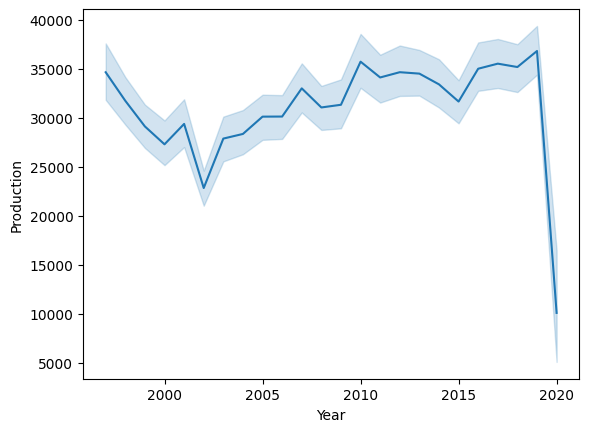

In [71]:
sns.lineplot(data=df1, x='Year',y='Production')

In [72]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190866 entries, 0 to 190865
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State       190866 non-null  object 
 1   District    190866 non-null  object 
 2   Crop        190866 non-null  object 
 3   Year        190866 non-null  int64  
 4   Season      190866 non-null  object 
 5   Area        190866 non-null  float64
 6   Production  190866 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 10.2+ MB


In [73]:
df = df1

In [74]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
import torch

label_encoders = {}
for column in ['State', 'District', 'Crop', 'Season']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Feature scaling
scalers = {}
for column in ['Area', 'Production']:
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df[[column]])
    scalers[column] = scaler

# Creating lag features
for lag in range(1, 13):  # 12 months lag
    df[f'Production_lag_{lag}'] = df['Production'].shift(lag)

# Dropping rows with NaN values after lag creation
df.dropna(inplace=True)

# Splitting into train and test sets based on time
train_size = int(len(df) * 0.8)
train_df, test_df = df[:train_size], df[train_size:]

df.info()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


<class 'pandas.core.frame.DataFrame'>
Index: 190854 entries, 12 to 190865
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              190854 non-null  int32  
 1   District           190854 non-null  int32  
 2   Crop               190854 non-null  int32  
 3   Year               190854 non-null  int64  
 4   Season             190854 non-null  int32  
 5   Area               190854 non-null  float64
 6   Production         190854 non-null  float64
 7   Production_lag_1   190854 non-null  float64
 8   Production_lag_2   190854 non-null  float64
 9   Production_lag_3   190854 non-null  float64
 10  Production_lag_4   190854 non-null  float64
 11  Production_lag_5   190854 non-null  float64
 12  Production_lag_6   190854 non-null  float64
 13  Production_lag_7   190854 non-null  float64
 14  Production_lag_8   190854 non-null  float64
 15  Production_lag_9   190854 non-null  float64
 16  Produc

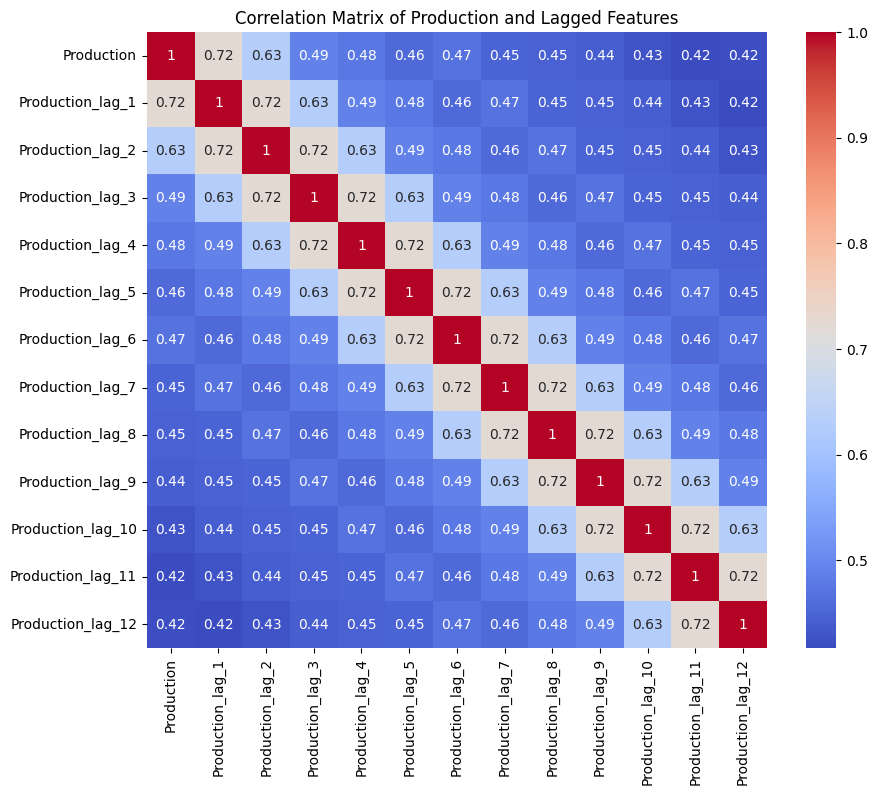

In [75]:
# Compute the correlation matrix
correlation_matrix = df[['Production'] + [f'Production_lag_{lag}' for lag in range(1, 13)]].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Production and Lagged Features')
plt.show()

In [76]:
def df_to_tensor(df, target_column):
    features = df.drop(columns=[target_column]).values
    target = df[target_column].values
    return torch.tensor(features, dtype=torch.float32).to(device), torch.tensor(target, dtype=torch.float32).to(device)

X_train, y_train = df_to_tensor(train_df, 'Production')
X_test, y_test = df_to_tensor(test_df, 'Production')

In [77]:
import torch.nn as nn
import torch

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 1

rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)

In [78]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1))  # Adjust target shape
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test.unsqueeze(1))  # Adjust target shape
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses, test_outputs

# Convert data to 3D tensors for RNNs (batch_size, sequence_length, input_size)
X_train_rnn = X_train.unsqueeze(1)
X_test_rnn = X_test.unsqueeze(1)

# Train RNN Model
train_losses_rnn, test_losses_rnn, rnn_predictions = train_model(rnn_model, X_train_rnn, y_train, X_test_rnn, y_test)

# Train LSTM Model
train_losses_lstm, test_losses_lstm, lstm_predictions = train_model(lstm_model, X_train_rnn, y_train, X_test_rnn, y_test)

# Train GRU Model
train_losses_gru, test_losses_gru, gru_predictions = train_model(gru_model, X_train_rnn, y_train, X_test_rnn, y_test)

Epoch [10/100], Train Loss: 1.0247, Test Loss: 1.1505
Epoch [20/100], Train Loss: 1.0097, Test Loss: 1.1367
Epoch [30/100], Train Loss: 0.9830, Test Loss: 1.1208
Epoch [40/100], Train Loss: 0.9817, Test Loss: 1.1193
Epoch [50/100], Train Loss: 0.9775, Test Loss: 1.1142
Epoch [60/100], Train Loss: 0.9750, Test Loss: 1.1123
Epoch [70/100], Train Loss: 0.9736, Test Loss: 1.1110
Epoch [80/100], Train Loss: 0.9721, Test Loss: 1.1094
Epoch [90/100], Train Loss: 0.9708, Test Loss: 1.1081
Epoch [100/100], Train Loss: 0.9696, Test Loss: 1.1067
Epoch [10/100], Train Loss: 0.9721, Test Loss: 1.1069
Epoch [20/100], Train Loss: 0.9705, Test Loss: 1.1056
Epoch [30/100], Train Loss: 0.9694, Test Loss: 1.1052
Epoch [40/100], Train Loss: 0.9685, Test Loss: 1.1041
Epoch [50/100], Train Loss: 0.9675, Test Loss: 1.1030
Epoch [60/100], Train Loss: 0.9662, Test Loss: 1.1019
Epoch [70/100], Train Loss: 0.9639, Test Loss: 1.0993
Epoch [80/100], Train Loss: 0.9607, Test Loss: 1.0962
Epoch [90/100], Train Loss:

RNN - MSE: 1.1067391633987427, MAE: 0.4367959201335907, R2: 0.0014873159871862107
LSTM - MSE: 1.0785483121871948, MAE: 0.42112553119659424, R2: 0.026921312844192413
GRU - MSE: 1.0328872203826904, MAE: 0.42123696208000183, R2: 0.06811725881085628


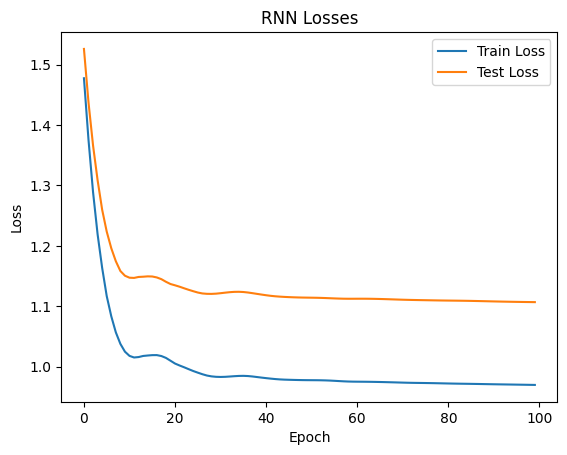

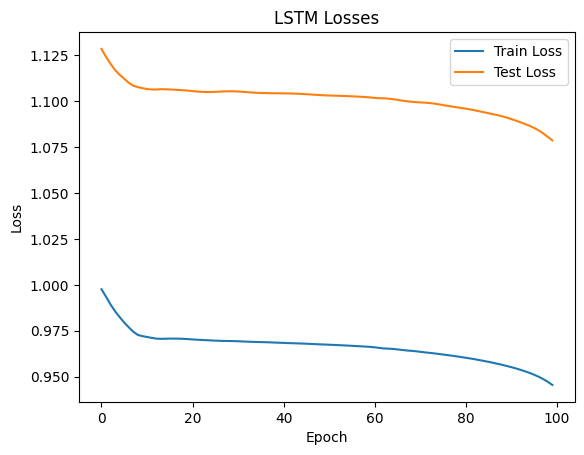

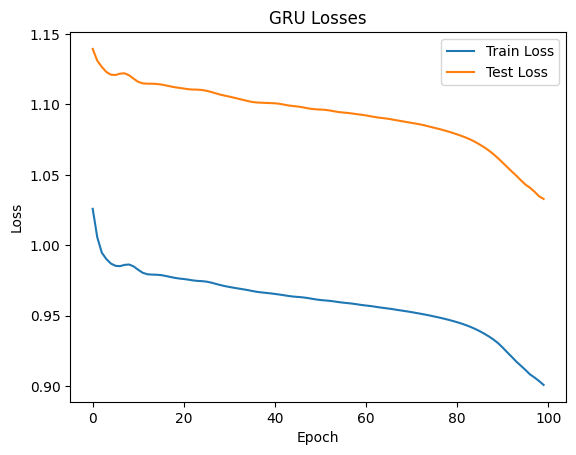

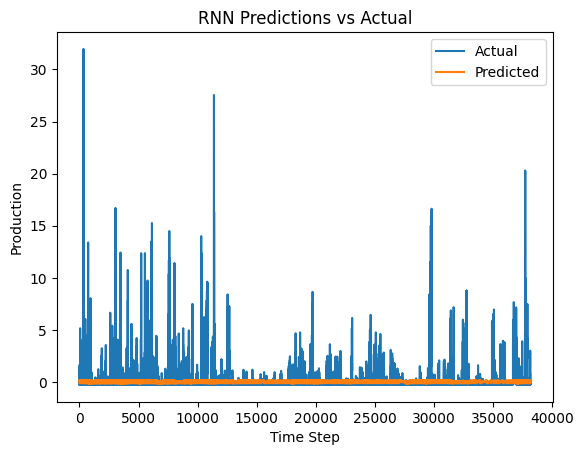

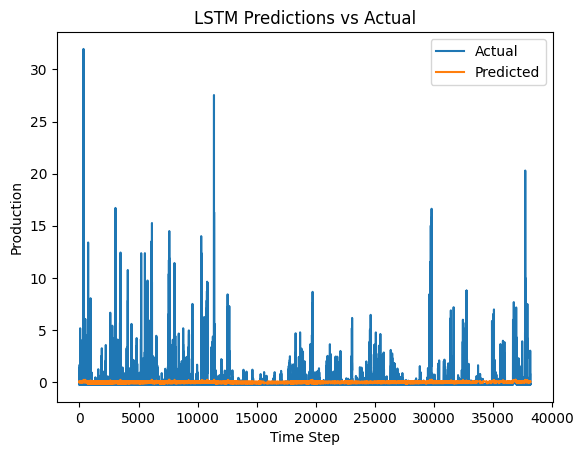

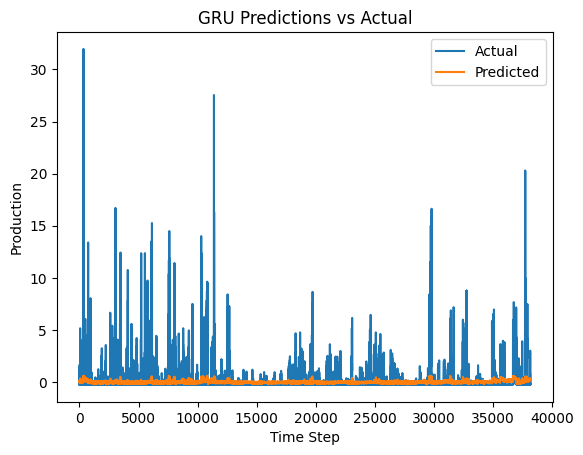

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(predictions, y_test):
    predictions = predictions.cpu().detach().numpy()
    y_test = y_test.cpu().numpy()
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, mae, r2

rnn_mse, rnn_mae, rnn_r2 = evaluate_model(rnn_predictions, y_test)
lstm_mse, lstm_mae, lstm_r2 = evaluate_model(lstm_predictions, y_test)
gru_mse, gru_mae, gru_r2 = evaluate_model(gru_predictions, y_test)

# Printing evaluation metrics
print(f"RNN - MSE: {rnn_mse}, MAE: {rnn_mae}, R2: {rnn_r2}")
print(f"LSTM - MSE: {lstm_mse}, MAE: {lstm_mae}, R2: {lstm_r2}")
print(f"GRU - MSE: {gru_mse}, MAE: {gru_mae}, R2: {gru_r2}")

# Plotting the training and test losses
import matplotlib.pyplot as plt


plt.plot(train_losses_rnn, label='Train Loss')
plt.plot(test_losses_rnn, label='Test Loss')
plt.title('RNN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(test_losses_lstm, label='Test Loss')
plt.title('LSTM Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_losses_gru, label='Train Loss')
plt.plot(test_losses_gru, label='Test Loss')
plt.title('GRU Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predicted vs Actual Plot
def plot_predictions(predictions, y_test, title):
    predictions = predictions.cpu().detach().numpy()
    actual = y_test.cpu().numpy()
    
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Production')
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(rnn_predictions, y_test, 'RNN Predictions vs Actual')
plot_predictions(lstm_predictions, y_test, 'LSTM Predictions vs Actual')
plot_predictions(gru_predictions, y_test, 'GRU Predictions vs Actual')


Epoch [10/1000], Train Loss: 0.9821, Test Loss: 1.1151
Epoch [20/1000], Train Loss: 0.9716, Test Loss: 1.1072
Epoch [30/1000], Train Loss: 0.9704, Test Loss: 1.1073
Epoch [40/1000], Train Loss: 0.9671, Test Loss: 1.1032
Epoch [50/1000], Train Loss: 0.9623, Test Loss: 1.0981
Epoch [60/1000], Train Loss: 0.9541, Test Loss: 1.0894
Epoch [70/1000], Train Loss: 0.9406, Test Loss: 1.0749
Epoch [80/1000], Train Loss: 0.9176, Test Loss: 1.0531
Epoch [90/1000], Train Loss: 0.8844, Test Loss: 1.0113
Epoch [100/1000], Train Loss: 0.8481, Test Loss: 0.9708
Epoch [110/1000], Train Loss: 0.7917, Test Loss: 0.9220
Epoch [120/1000], Train Loss: 0.7510, Test Loss: 0.8829
Epoch [130/1000], Train Loss: 0.7134, Test Loss: 0.8397
Epoch [140/1000], Train Loss: 0.6386, Test Loss: 0.7610
Epoch [150/1000], Train Loss: 0.5801, Test Loss: 0.7066
Epoch [160/1000], Train Loss: 0.5566, Test Loss: 0.6851
Epoch [170/1000], Train Loss: 0.5352, Test Loss: 0.6577
Epoch [180/1000], Train Loss: 0.5193, Test Loss: 0.6378
E

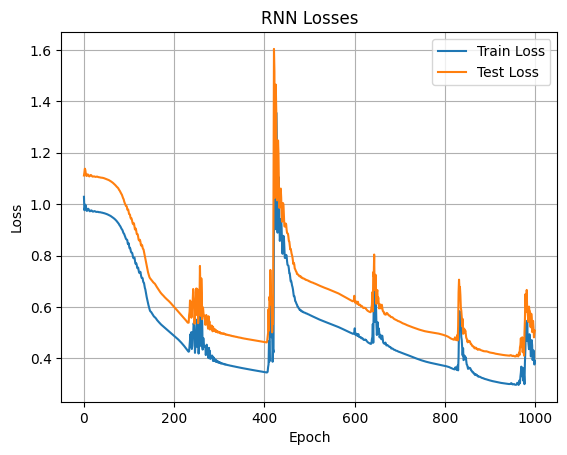

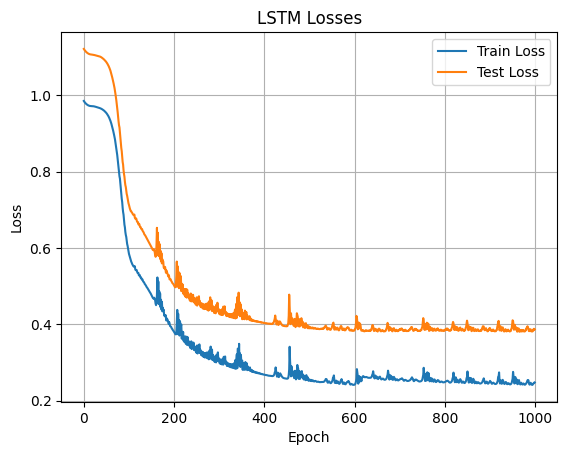

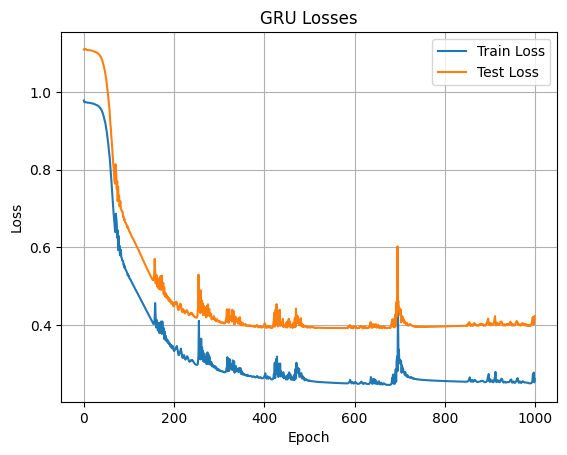

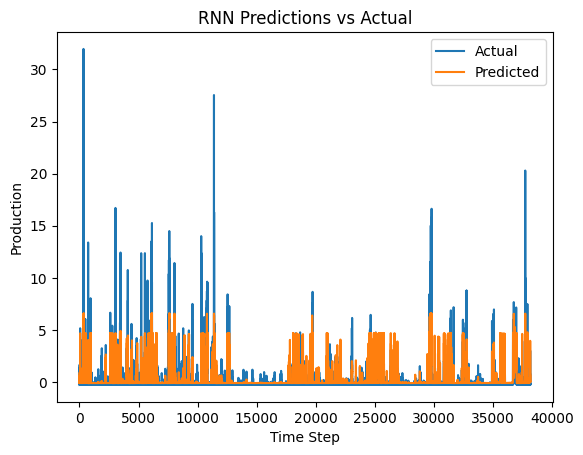

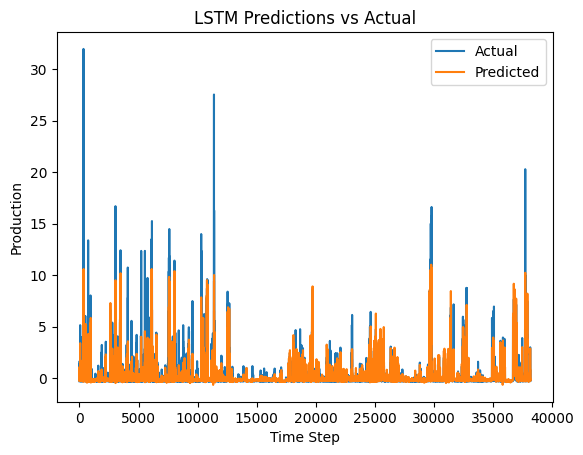

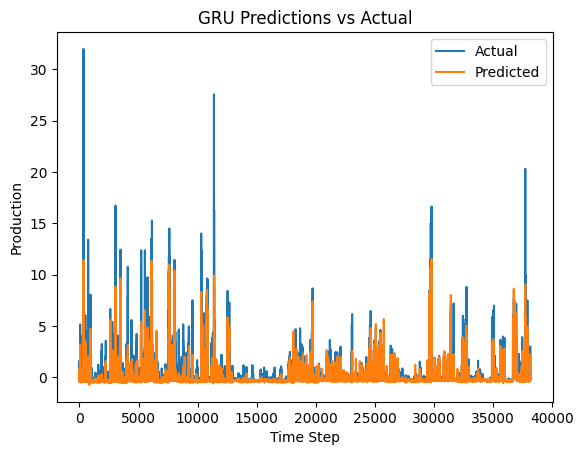

In [89]:

input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 3
num_epochs = 1000

rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)


X_train_rnn = X_train.unsqueeze(1)
X_test_rnn = X_test.unsqueeze(1)
train_losses_rnn, test_losses_rnn, rnn_predictions = train_model(rnn_model, X_train_rnn, y_train, X_test_rnn, y_test,num_epochs)
train_losses_lstm, test_losses_lstm, lstm_predictions = train_model(lstm_model, X_train_rnn, y_train, X_test_rnn, y_test,num_epochs)
train_losses_gru, test_losses_gru, gru_predictions = train_model(gru_model, X_train_rnn, y_train, X_test_rnn, y_test,num_epochs)


rnn_mse, rnn_mae, rnn_r2 = evaluate_model(rnn_predictions, y_test)
lstm_mse, lstm_mae, lstm_r2 = evaluate_model(lstm_predictions, y_test)
gru_mse, gru_mae, gru_r2 = evaluate_model(gru_predictions, y_test)

print(f"RNN - MSE: {rnn_mse}, MAE: {rnn_mae}, R2: {rnn_r2}")
print(f"LSTM - MSE: {lstm_mse}, MAE: {lstm_mae}, R2: {lstm_r2}")
print(f"GRU - MSE: {gru_mse}, MAE: {gru_mae}, R2: {gru_r2}")

plt.plot(train_losses_rnn, label='Train Loss')
plt.plot(test_losses_rnn, label='Test Loss')
plt.title('RNN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(test_losses_lstm, label='Test Loss')
plt.title('LSTM Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_losses_gru, label='Train Loss')
plt.plot(test_losses_gru, label='Test Loss')
plt.title('GRU Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plot_predictions(rnn_predictions, y_test, 'RNN Predictions vs Actual')
plot_predictions(lstm_predictions, y_test, 'LSTM Predictions vs Actual')
plot_predictions(gru_predictions, y_test, 'GRU Predictions vs Actual')